# Kaggle Facial Keypoint Detection

# Ideas

### Pretraining
- data augmentation
- normalisation


### Model
- make a basic CNN model
- Transfer learning from a pretrained model like VGG-19 or RESNET
- More complicated systems
  - Vision transformers
  - 

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df = df.dropna()

len(df)

2140

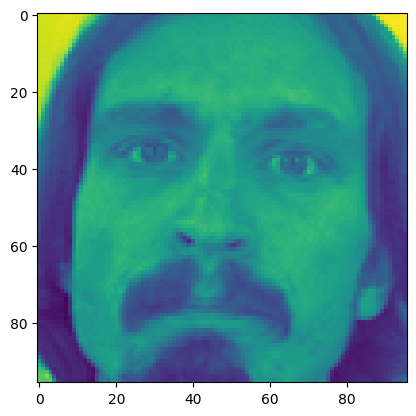

In [4]:
im = np.array(df['Image'][0].split(), dtype=np.int32).reshape(96,-1)
plt.imshow(im)


In [5]:
X, y = [], []

In [6]:
for i in df['Image']:
    X.append(i.split(' '))

In [7]:
y = torch.tensor(df.drop('Image', axis=1).values)
y.shape

torch.Size([2140, 30])

In [8]:
y

tensor([[66.0336, 39.0023, 30.2270,  ..., 72.9355, 43.1307, 84.4858],
        [64.3329, 34.9701, 29.9493,  ..., 70.2666, 45.4679, 85.4802],
        [65.0571, 34.9096, 30.9038,  ..., 70.1918, 47.2749, 78.6594],
        ...,
        [68.4309, 38.6520, 28.8959,  ..., 79.0431, 47.1767, 89.5445],
        [64.1522, 30.6916, 27.0009,  ..., 79.3014, 58.6111, 80.3555],
        [66.6838, 34.4834, 30.7845,  ..., 75.9636, 52.9234, 82.6611]],
       dtype=torch.float64)

In [9]:
X = [list(map(int, x)) for x in X]
X = torch.tensor(X)
X = (X/255.).view(-1, 1, 96,96)
X.shape

torch.Size([2140, 1, 96, 96])

In [10]:
class FaceDataset(Dataset):
    def __init__(self, train=True):
        df = pd.read_csv('data/train.csv')
        df = df.dropna()
        X = []
        for i in df['Image']:
            X.append(i.split(' '))
        X = [list(map(int, x)) for x in X]
        X = torch.tensor(X)
        df.drop('Image', axis=1 )
        if train:
            self.X = (X/255.).view(-1, 1, 96,96)[:1500]
            self.y = torch.tensor(df.drop('Image', axis=1).values)[:1500]
        else:
            self.X = (X/255.).view(-1, 1, 96,96)[1500:]
            self.y = torch.tensor(df.drop('Image', axis=1).values)[1500:]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [11]:
train_dataset = FaceDataset(train=True)
val_dataset = FaceDataset(train=False)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=True, num_workers=0)

# Model

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 21 * 21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 21 * 21)
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x   

# Training

In [13]:
num_epochs = 500
lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
model = CNN().to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=lr)
train_history = {}
val_history = {}

In [15]:
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        loss = loss_category(y_pred.float(), labels.float())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f'Epoch: {epoch} Loss: {loss}')
    train_history[epoch] = loss.cpu().detach().numpy()

    if epoch%50 == 0 or epoch==num_epochs-1:
        # validation split
        model.eval()
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            y_pred = model(inputs)

            loss = loss_category(y_pred.float(), labels.float())
            val_history[epoch] = loss.cpu().detach().numpy()
        model.train()
            

Epoch: 0 Loss: 2643.615234375
Epoch: 1 Loss: 2640.7333984375
Epoch: 2 Loss: 2638.27099609375
Epoch: 3 Loss: 2655.53857421875
Epoch: 4 Loss: 2632.222412109375
Epoch: 5 Loss: 2668.067138671875
Epoch: 6 Loss: 2649.09033203125
Epoch: 7 Loss: 2632.948486328125
Epoch: 8 Loss: 2629.875244140625
Epoch: 9 Loss: 2630.33544921875
Epoch: 10 Loss: 2606.596923828125
Epoch: 11 Loss: 2595.783935546875
Epoch: 12 Loss: 2596.154296875
Epoch: 13 Loss: 2587.42529296875
Epoch: 14 Loss: 2556.0888671875
Epoch: 15 Loss: 2528.91064453125
Epoch: 16 Loss: 2495.728271484375
Epoch: 17 Loss: 2439.31982421875
Epoch: 18 Loss: 2411.029296875
Epoch: 19 Loss: 2363.87255859375
Epoch: 20 Loss: 2271.851318359375
Epoch: 21 Loss: 2181.214599609375
Epoch: 22 Loss: 2064.354736328125
Epoch: 23 Loss: 1929.8626708984375
Epoch: 24 Loss: 1825.914794921875
Epoch: 25 Loss: 1644.795166015625
Epoch: 26 Loss: 1434.834228515625
Epoch: 27 Loss: 1243.5726318359375
Epoch: 28 Loss: 1046.8858642578125
Epoch: 29 Loss: 816.8232421875
Epoch: 30 L

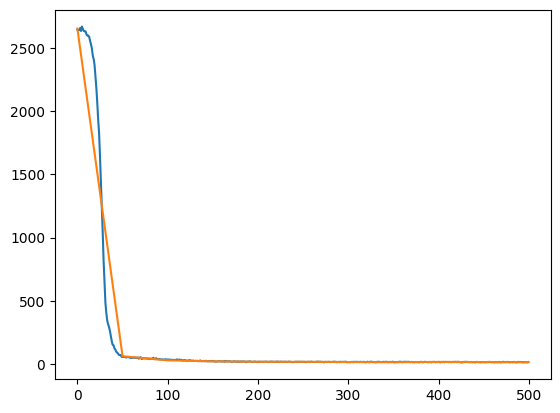

In [19]:
plt.plot(train_history.keys(), train_history.values())
plt.plot(val_history.keys(), val_history.values())

In [18]:
torch.save(model, 'saves/model1.pt')

# TODO

- Do proper init
- validation
- lr scheduling
- weight decay
- lr decay
- dropout